# [Inference] Main Training

In [2]:
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm
import pickle

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
from sklearn.preprocessing import LabelEncoder
import random
from datetime import datetime
import pytz
import line_profiler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fix Random Seeds

In [2]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

## Prepare Data

In [3]:
CONTEXT_REPS = pd.read_pickle('../../data/w_final_context.pkl')
STREAM_ITEM_DICT = pd.read_pickle('../../data/stream_item_dict.pkl')
BERT_BY_IDX_DF = pd.read_pickle('../../data/bert_by_idx_pca.pkl')
BOUGHT_DICT = pd.read_pickle('../../data/bought_dict.pkl')
USER_ALL_STREAM_INIT = CONTEXT_REPS.describe().loc['50%']

In [4]:
CONTEXT_REPS.shape, len(STREAM_ITEM_DICT), BERT_BY_IDX_DF.shape, len(BOUGHT_DICT)

((1397141, 219), 7701, (162189, 160), 79207)

In [5]:
USER_LIST = CONTEXT_REPS.index.get_level_values('asid').tolist()

In [6]:
LB_ITEMS = ['item_id'] + [f'i{x}' for x in range(160)]
INPUT_DF_COL__USR = CONTEXT_REPS.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS

'''
METHOD FOR BOTH EXP_REPLAY & DQN
Convert state format to model input format
'''
def get_input_tensor(input_state, current_stream, with_tensor=False):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})

  # Fill in other context
  stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
  
  # Merge with items
  stream_item_feat = stream_item_feat.merge(item_feat, left_index=True, right_index=True).astype('float32')
  
  # Convert to tensor
  if with_tensor: 
    stream_item_feat_tensor = df_to_tensor(stream_item_feat)
    return stream_item_feat_tensor, stream_item_feat
  else:
    return stream_item_feat

In [7]:
'''
METHOD FOR BOTH EXP_REPLAY & DQN

Generate series: whether elements in A existed in list B
A, B: List
return: pd.Series
example:
  A: [1, 2, 4, 5]
  B: [1, 2, 3, 4, 5, 6, 7]
  return: Series([1, 1, 0, 1, 1, 0, 0], index=[1, 2, 3, 4, 5, 6, 7])
'''
def gen_exist_series(A, B):
  return [int(item in A) for item in B]

In [8]:
def df_to_tensor(input_df):
  return torch.tensor(input_df.values).to(DEVICE).float()

---

## Replay

In [4]:
class ReplayBuffer:
  def __init__(self, max_memory=100000, discount=.9, model_output_shape=1):
    """
    Setup
    max_memory: the maximum number of experiences we want to store
    memory: a list of experiences
    discount: the discount factor for future experience
    In the memory the information whether the game ended at the state is stored seperately in a nested array
    [...
    [experience, game_over]
    [experience, game_over]
    ...]
    """
    self.max_memory = max_memory
    self.memory = list()
    self.discount = discount
    self.model_output_shape = model_output_shape

  def remember(self, states, game_over):
    # Save a state to memory
    self.memory.append([states, game_over])
    # We don't want to store infinite memories, so if we have too many, we just delete the oldest one
    if len(self.memory) > self.max_memory:
      del self.memory[0]

  def get_batch(self, eval_net, target_net, batch_size=10):
    # How many experiences do we have?
    len_memory = len(self.memory)

    # Calculate the number of actions that can possibly be taken in the game.
    # Actions: 0 = not recommend, 1 = recommend
    num_actions = self.model_output_shape

    # Dimensions of our observed states, ie, the input to our model.
    # Memory:  [
    #   [ [ [stream, next_stream], [...state], action, reward, next_state_idx], game_over],
    #   [ [ [stream, next_stream], [...state], action, reward, nexr_state_idx], game_over],
    #   ...
    # ]
    env_dim = len(INPUT_DF_COL)

    inputs = pd.DataFrame()
    targets = torch.tensor([], dtype=torch.float32).to(DEVICE)
    
    
    # We draw states to learn from randomly
    for i, idx in enumerate(np.random.randint(0, len_memory, size=min(len_memory, batch_size))):  
      # Here we load one transition <s, a, r, s'> from memory
      streams, state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
      current_stream, next_stream = streams
      game_over = self.memory[idx][1]

      '''
      修改倒入 state 的方式 input = (state - item) + item_feat
      拆掉 model_predict 成 function
      
      here should be state_t * all_items
      '''
      state_tensor, state_t = get_input_tensor(state_t, current_stream, with_tensor=True)
      # puts state into input
      inputs = pd.concat([inputs, state_t], axis=0)
      
      # use target_net to predict target for eval_net to learn
      current_target = target_net(state_tensor).detach().view(len(reward_t), 1)

      selected_ids = np.where(action_t > 0)[0]
      reward_t = df_to_tensor(reward_t).view(len(reward_t), 1)
      
      
      '''
      每個 actions 都會被 predict 一個成績/reward
      '''
      # if the game ended, the reward is the final reward
      if game_over:  # if game_over is True
        current_target[selected_ids] = reward_t[selected_ids]
      else:
        state_tp1, _ = get_input_tensor(state_tp1, next_stream, with_tensor=True)
        Q_sa = torch.max(target_net(state_tp1).detach())
        
        # r + gamma * max Q(s',a')
        # current_target = reward_t + self.discount * Q_sa
        current_target[selected_ids] = reward_t[selected_ids] + Q_sa * self.discount

      targets = torch.cat((targets, current_target), 0)
    return inputs, targets

## Epsilon

In [5]:
from abc import ABC, abstractmethod
import math

class Epsilon(ABC):
  @abstractmethod
  def clear(self):
    pass
  
  @abstractmethod
  def get_epsilon(self, key):
    pass
  
  @abstractmethod
  def update_at_step(self, key, data):
    pass
  
  @abstractmethod
  def update_at_epoch(self, data):
    pass
  
  # @abstractmethod
  # def update_at_epsisode():
  #   pass


class Decay(Epsilon):
  # Ref: Decay(0.5, 0.85)
  '''
  Epsilon Decay EE method with update/decay at epoch
  '''
  def __init__(self, initial, epoch_decay, step_decay):
    self.initial = initial
    self.epoch_decay, self.step_decay = epoch_decay, step_decay
    self.epsilon = self.initial
    
  def clear(self):
    self.epsilon = self.initial # should be 4 for origin setting
    
  def get_epsilon(self, key):
    return self.epsilon
  
  def update_at_step(self, key, data):
    # origin setting
    pass
    # exponentially
    # self.epsilon *= self.step_decay
    
  def update_at_epoch(self, data):
    # origin settings
    epoch = data
    self.epsilon = 4 / ((epoch + 1) ** (1 / 2))
    # exponentially
    # self.epsilon *= self.epoch_decay


class VDBE(Epsilon):
  # VDBE(0.5, 0.01)
  def __init__(self, initial, sigma):
    self.initial = initial
    self.sigma = sigma

  def clear(self):
    self.epsilon = defaultdict(lambda: self.initial)

  def get_epsilon(self, key):
    return self.epsilon[key]
  
  def update_at_step(self, key, data, delta):
    td_error = data
    coeff = math.exp(-abs(td_error) / self.sigma)
    f = (1.0 - coeff) / (1.0 + coeff)
    self.epsilon[key] = delta * f + (1.0 - delta) * self.epsilon[key]
  
  def update_at_epoch(self, data):
    pass

## DQN

In [6]:
class DQN(object):
  def __init__(self, exp_replay, epsilon, num_episode, epochs, batch_size, lr, switch_param_threshold):
    self.eval_net, self.target_net = Net(), Net()
    self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
    self.loss_fn = nn.MSELoss()
    self.exp_replay = exp_replay
    self.epsilon = epsilon
    self.num_episode = num_episode
    self.epochs = epochs
    self.batch_size = batch_size
    self.switch_param_threshold = switch_param_threshold
    self.user_all_stream_init = USER_ALL_STREAM_INIT
    self.hist = []
    self.c_hist = []
    self.rec_list = []
    self.ep_score_list = []
    self.learn_step_counter = 0

  # Environment Methods
  def __episodes(self):
    # return USER_LIST[:self.num_episode]
    return np.random.choice(USER_LIST, self.num_episode, replace=False)
  
  def __user_episode_context(self):
    self.user_all_streams = CONTEXT_REPS.xs(self.asid, level="asid")
    self.stream_list = self.user_all_streams.index
    self.final_stream = max(self.stream_list)
  
  def __full_state(self, i):
    '''
    retrieve full state -> should be exported to pickle
    '''
    if (i - 1) == -1:
      user_part = self.user_all_stream_init.copy()
      user_part.name = self.stream_list[i]
    else:
      user_part = self.user_all_streams.loc[self.stream_list[(i - 1)]]
    return user_part

  def reward(self):
    '''
    Comparison function for reward, 考慮「所有」歷史購買紀錄
    '''
    real_bought_ids = BOUGHT_DICT[self.asid]
    real_bought_ids_series = gen_exist_series(real_bought_ids, self.stream_items)
    
    reward_list = [a & b for a, b in zip(real_bought_ids_series, self.action_ids)]
    # Reward Count 
    self.rec_cnt += 1
    if sum(reward_list) > 0:
      self.c_win_cnt += 1
      self.win_cnt += 1
      self.ep_score += sum(reward_list)
    # return list(map(lambda x: x * sum(reward_list), reward_list))
    return pd.Series(list(map(lambda x: x * sum(reward_list), reward_list)), index=self.stream_items)

  # Agent Methods
  def __choose_actions(self):
    if np.random.rand() <= self.epsilon.get_epsilon(f'{self.asid}-{self.current_stream}'):
    # if len(self.exp_replay.memory) < 1:
      # Explore by randomly select 10/n items from candidate_items
      # Get all items from the stream
      self.explore += 1
      selected_actions = random.sample(self.stream_items, 10) if len(self.stream_items) > 10 else self.stream_items
    else:
      # Exploit by choosing action from the model's prediction
      self.exploit += 1
      selected_actions = self.__agent_predict()
    x = pd.Series(0, index=self.stream_items)
    x.loc[selected_actions] = 1
    return x
    
  def q_value(self): 
    if type(self.epsilon) == Decay: return 0

    predicts = self.eval_net(self.full_input).flatten()    
    actions_idx = np.where(self.action_ids.values == 1)[0]
    q_val = predicts[actions_idx].mean()
    return q_val

  def __agent_predict(self):
    predicts = self.eval_net(self.full_input).flatten()
    if len(predicts) > 10:
      top10_idx = torch.topk(predicts, 10).indices.cpu()
      actions = self.candidate_actions.iloc[top10_idx]['item_id'].values
    else:
      actions = self.candidate_actions['item_id'].values
    return actions

  def __train_agent_batch(self, inputs, targets):
    self.optimizer.zero_grad()
    outputs = self.eval_net(inputs)
    loss = self.loss_fn(outputs, targets)
    # Add CL Regularization Term
    loss.backward()
    self.optimizer.step()
    return loss.item()
  
  def inference(self, state):
    self.asid, self.current_stream = state.name
    self.stream_items = STREAM_ITEM_DICT[self.current_stream]
    self.full_input, self.candidate_actions = get_input_tensor(state, self.current_stream, with_tensor=True)
    selected_actions = self.__agent_predict().astype(int)
    reward = self.reward()
    reward = reward.loc[reward > 0].index.tolist()
    return selected_actions, reward

  # MAIN TRAIN
  def train(self):
    self.eval_net.to(DEVICE)
    self.target_net.to(DEVICE)
    self.c_win_cnt = 0
    self.eval_net.train(True)
    self.epsilon.clear()

    for e in self.epochs:
      self.rec_cnt = 0
      self.win_cnt = 0
      self.loss = 0.
      self.ep_score = 0
      self.explore = 0
      self.exploit = 0
    
      print(f'Epoch {e} started.   Time: {datetime.now(pytz.timezone("Asia/Taipei")).strftime("%H:%M:%S")}')
      # ------------------- Episode (User) -------------------------------
      for asid in tqdm(self.__episodes()):
        self.asid = asid
        self.__user_episode_context()

        # ----------------- Runs (User x All_Stream) ---------------------
        for i, stream in enumerate(self.stream_list):
          game_over = stream == self.final_stream
          self.current_stream = stream
          self.current_state = self.__full_state(i)
          self.stream_items = STREAM_ITEM_DICT[self.current_stream]
          self.full_input, self.candidate_actions = get_input_tensor(self.current_state, self.current_stream, with_tensor=True)

          # --------------- Explore/Exploit Section ----------------------
          self.action_ids = self.__choose_actions()

          # --------------- Get next state & info to store ---------------
          reward = self.reward()
          next_state = self.__full_state(i+1) if not game_over else []
          next_stream = 0 if (i + 1) == len(self.stream_list) else self.stream_list[i + 1]
          self.exp_replay.remember([[stream, next_stream], self.current_state, self.action_ids, reward, next_state], game_over)
          self.learn_step_counter += 1
          if self.learn_step_counter % self.switch_param_threshold == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())


          # --------------- Load batch of experiences --------------------
          inputs, targets = self.exp_replay.get_batch(self.eval_net, self.target_net, batch_size=self.batch_size)
          inputs = df_to_tensor(inputs)
          # store pre-training value for td_error
          old_Q = self.q_value()
          batch_loss = self.__train_agent_batch(inputs, targets)
          # store post-training value for td_error
          new_Q = self.q_value()
          self.loss += batch_loss

          # --------------- Update with TD error -------------------------
          self.epsilon.update_at_step(f'{self.asid}-{self.current_stream}', (new_Q - old_Q), len(self.stream_items))

      # Track win history to later check if our model is improving at the game over time.
      self.hist.append(self.win_cnt)
      self.c_hist.append(self.c_win_cnt)
      self.rec_list.append(self.rec_cnt)
      self.ep_score_list.append(self.ep_score)

      print(f'Epoch: {e}/{len(self.epochs)} | Loss {self.loss} | Epoch Hit Rate {self.win_cnt/self.rec_cnt} | \
              Cumulative Hit Rate {self.c_win_cnt/sum(self.rec_list)} | Explore {self.explore} | Exploit {self.exploit} | \
              Score {self.ep_score}')

## Main Method

In [7]:
pd.set_option('mode.chained_assignment', None)

# parameters
MAX_MEMORY = 1000  # Maximum number of experiences we are storing
BATCH_SIZE = 2  # Number of experiences we use for training per batch
EPOCH = range(100)
TOTAL_ACTIONS = 1 # probability of ordering
NUM_EPISODE = 100
HIDDEN_SIZE = 512
LR = 1.0e-4
SWITCH_PARAM_THRESHOLD = 100

warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(380, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.tanh(x)
    x = self.fc5(x)
    return x

## Inference

In [111]:
item_list = pd.read_pickle('../../data/index_to_item_list.pkl')

In [9]:
vdbe_ddqn = pd.read_pickle('../Models/vdbe_100_ddqn.pkl')

In [10]:
vdbe_target = pd.read_pickle('../Models/vdbe_100_target.pkl')

In [13]:
vanilla = pd.read_pickle('../Models/vanilla_100.pkl')

In [113]:
vdbe_ddqn.eval_net

Net(
  (fc1): Linear(in_features=380, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [114]:
selected_items, rewards = vdbe_ddqn.inference(CONTEXT_REPS.iloc[0])

In [115]:
for i in selected_items: print(item_list[i])

秀炮 0614 A19-飛狼 SWAG 極限冰鋒杯 (內膽316)-灰*1
秀炮 0614 A18-飛狼 SWAG 極限冰鋒杯 (內膽316)-黑*1
公主 0614 G01-(1個)防護面罩(單個)*1---刪單不通知
公主 0614 G02-(1支)B北歐不鏽鋼防滑衣架 (單支)*1---刪單不通知
888 0614 G03-(1盒)防護口罩-平面款(50片/盒)(成人17.5*9.5)(非醫療級)(包裝隨機)(顏色隨機)*1
秀炮 0614 A17-NICONICO雙效空氣清淨電子除濕機 NI-DC1004*1
888 0614 G04-(1盒)防護口罩-平面款(50片/盒)(兒童14.5*9.5)(非醫療級)(包裝隨機)(顏色隨機)*1
888 0614 G05-(1包)嬰幼兒長效防護噴霧<補充液>500ML*1
秀炮 0614 A20-飛狼 SWAG 極限冰鋒杯 (內膽316)-黃*1
公主 0614 G03-(1盒)防護口罩-平面款(50片/盒)(成人17.5*9.5)(非醫療級)(包裝隨機)(顏色隨機)*1


In [116]:
for i in rewards: print(item_list[i])

秀炮 0614 A19-飛狼 SWAG 極限冰鋒杯 (內膽316)-灰*1
秀炮 0614 A20-飛狼 SWAG 極限冰鋒杯 (內膽316)-黃*1


In [ ]:
res_ddqn = [a/b for a, b in zip(vdbe_ddqn.hist, vdbe_ddqn.rec_list)]
res_target = [a/b for a, b in zip(vdbe_target.hist, vdbe_target.rec_list)]
res_vanilla = [a/b for a, b in zip(vanilla.hist, vanilla.rec_list)]

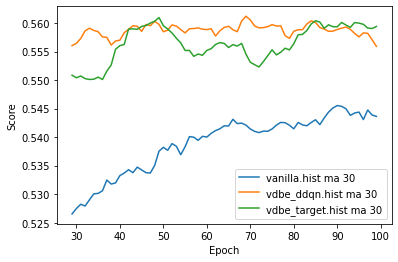

In [ ]:
plt.plot(pd.Series(res_vanilla).rolling(30).mean(), label='vanilla.hist ma 30')
plt.plot(pd.Series(res_ddqn).rolling(30).mean(), label='vdbe_ddqn.hist ma 30')
plt.plot(pd.Series(res_target).rolling(30).mean(), label='vdbe_target.hist ma 30')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

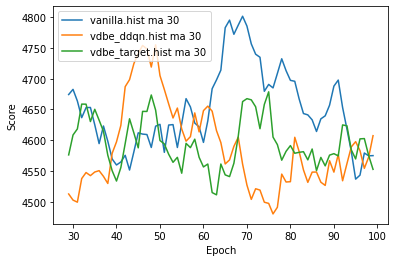

In [24]:
plt.plot(pd.Series(vanilla.rec_list).rolling(30).mean(), label='vanilla.hist ma 30')
plt.plot(pd.Series(vdbe_target.rec_list).rolling(30).mean(), label='vdbe_ddqn.hist ma 30')
plt.plot(pd.Series(vdbe_ddqn.rec_list).rolling(30).mean(), label='vdbe_target.hist ma 30')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()